In [1]:
from magicgui import magicgui
import datetime
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import napari
from magicclass import magicclass, field
from magicclass.widgets import Figure
import numpy as np
from scipy.stats import gaussian_kde
from tifffile import TiffFile
import vispy.color
from typing import List

%config Completer.use_jedi = False


sns.set_style("ticks")
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def getLabels(tif_tags):
    substr = "<ScanColorTable-k>"
    start = 0
    strings = []
    while True:
        start = tif_tags['ImageDescription'].find(substr, start)
        if start == -1: # when '<ScanColorTable-k>' is not found
            break
        string = tif_tags['ImageDescription'][start+18:start+26]
        strings.append(string)
        start += 1
    marquages = []
    wl = []
    for s in strings:
        if s.startswith('DAPI'):
            marquages.append(s[0:4])
            wl.append('450')
        if s.startswith('Opal'):
            marquages.append(s)
            wl.append(s[5:])
            
    dictionary = {key: value for key, value in enumerate(wl)}
    # change to detailled list
    channel_list = [f'{value} (channel {key})' for key, value in enumerate(marquages)]

    return channel_list, dictionary

In [3]:
def get_cells(data, phe):
    dataPhe = []
    for p in phe:
        dataPhe.append(data.loc[data['phenotype'] == p])
    dataPhe = pd.concat(dataPhe)
    pointsPhe = np.column_stack((dataPhe['nucleus.x'], dataPhe['nucleus.y'])).astype(float)
    return pointsPhe

In [4]:
def convert_micro_to_pixels(tif_tags, points):
    scale = 10000
    #Compute min X and Y positions in micro meter
    X_ULHC = tif_tags['XPosition'][0]/tif_tags['XPosition'][1]*scale
    Y_ULHC = tif_tags['YPosition'][0]/tif_tags['YPosition'][1]*scale

    # Subtract the upper-left-hand corner (ULHC) 
    # to convert from the original system coordinate (full scan) to the cropped one
    x_values = (points[:,0] - X_ULHC) 
    y_values = (points[:,1] - Y_ULHC)
    
    # Get the resolution of the image
    numerator, denominator = tif_tags['XResolution']
    x_resolution = numerator / denominator
    numerator, denominator = tif_tags['YResolution']
    y_resolution = numerator / denominator
    resolution = np.array([x_resolution, y_resolution])/scale
    
    # Convert the coordinates to pixels
    points_ULHC = np.vstack((x_values, y_values)).T
    pixel_points = points_ULHC * resolution
    
    #save points in coordinates (0,0)
    points_microM = points - np.array([X_ULHC, Y_ULHC])

    return pixel_points, points_microM

In [5]:
def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255

    factor = 0.0
    R = G = B = 0

    if (wavelength >= 380) and (wavelength < 440):
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif (wavelength >= 440) and (wavelength < 490):
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif (wavelength >= 490) and (wavelength < 510):
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif (wavelength >= 510) and (wavelength < 580):
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif (wavelength >= 580) and (wavelength < 645):
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif (wavelength >= 645) and (wavelength <= 750):
        R = 1.0
        G = 0.0
        B = 0.0

    # Adjust intensity
    if (wavelength >= 380) and (wavelength <= 750):
        factor = 0.3 + 0.7 * (wavelength - 380) / (750 - 380)

    R = int(intensity_max * (R * factor)**gamma)
    G = int(intensity_max * (G * factor)**gamma)
    B = int(intensity_max * (B * factor)**gamma)

    return [R / 255.0, G / 255.0, B / 255.0]

In [6]:
# Path for the .qptiff
# 1ere lame
#path = "../data/DC2 CheckUp B200332_Scan1/Scan1/DC2 CheckUp B200332_Scan1.qptiff"

# Test pierre
path = "../data/Pierre_good/DC2 CheckUp B191914_Scan1.qptiff"

# Load file
tif = TiffFile(path)
# Load multi channel image
img_data = tif.series[0].asarray()
# Get tags from DAPI channel in .pages
tif_tags = {}
for tag in tif.pages[0].tags.values():
    name, value = tag.name, tag.value
    tif_tags[name] = value

In [7]:
channel_list, channel_name_dictionary = getLabels(tif_tags)
channel_list

['DAPI (channel 0)',
 'Opal 570 (channel 1)',
 'Opal 690 (channel 2)',
 'Opal 480 (channel 3)',
 'Opal 620 (channel 4)',
 'Opal 780 (channel 5)',
 'Opal 520 (channel 6)']

In [8]:
# 1ere lame
#file_path_csv = "../data/DC2 CheckUp B200332_Scan1 2/Consolidated_data_new.txt"
# Test pierre
file_path_csv = '../data/Pierre_good/Consolidated_data_new_good.txt'

data = pd.read_csv(file_path_csv, sep="\t")
data = data.dropna()

# Keep marker columns
cols = [i for i in data.columns if 
        i.startswith(("Nucleus", "Membrane", "Cytoplasm", "Cell")) and 
        i not in ["Cell ID", "Cell X Position", "Cell Y Position", "Nucleus Area (square microns)"]]

# Store possible celltypes in the dataframe
celltype_cols = [i for i in data.columns if i.startswith("Phenotype")]
celltype = [i.split()[1] for i in celltype_cols]

# Initialisation
x = np.log(data[cols[0]])
y = np.log(data[cols[1]])

In [9]:
# Adding phenotype column in dataframe

data_shrink = data[celltype_cols]

# Pneumocytes -> cDC1 -> pDC -> cDC2 -> Tumor_cells -> CD8 -> Other

liste_phenotype = []

# 1ere lame
#dico = {"CD8" : 0, "Tumor" : 1, "Other.X" : 2, "Pneumocytes" : 3, "Other.y" : 4, "cDC2" : 5, "pDC" : 6, "cDC1" : 7, "Mature_DC" : 8}

# Test pierre
dico = {"CD8" : 1, "Tumor" : 2, "Other.X" : 0, "Pneumocytes" : 4, "Other.y" : 5, "cDC2" : 7, "pDC" : 8, "cDC1" : 6, "Mature_DC" : 3}

for i in range(len(data_shrink.index)):
    if "+" in data_shrink.iloc[i, dico["Pneumocytes"]]:
        liste_phenotype.append("Pneumocytes")
    elif "+" in data_shrink.iloc[i, dico["cDC1"]]:
        liste_phenotype.append("cDC1")
    elif "+" in data_shrink.iloc[i, dico["pDC"]]:
        liste_phenotype.append("pDC")
    elif "+" in data_shrink.iloc[i, dico["cDC2"]]:
        liste_phenotype.append("cDC2")
    elif "+" in data_shrink.iloc[i, dico["Mature_DC"]]:
        liste_phenotype.append("Mature_DC")
    elif "+" in data_shrink.iloc[i, dico["Tumor"]]:
        liste_phenotype.append("Tumor")
    elif "+" in data_shrink.iloc[i, dico["CD8"]]:
        liste_phenotype.append("CD8")
    else:
        liste_phenotype.append("Other")
        
data["Phenotype"] = liste_phenotype

In [10]:
data["Phenotype"].value_counts()

Phenotype
Other          495667
Tumor           75613
CD8             31631
Mature_DC       17758
cDC2             3169
cDC1             2661
pDC              1890
Pneumocytes       254
Name: count, dtype: int64

In [11]:
options = {"widget_type": "FloatSlider", "min": np.min(x), "max": np.max(x)}
dropdown={"choices" : cols}
dropdown2={"choices": cols}

Phenotypes = list(np.unique(data["Phenotype"]))
dropdown3 = {"widget_type" : 'Select', "choices" : Phenotypes, "value" : Phenotypes[0]}

In [13]:
# app trop lente quand beaucoup de cellules, essayer d'afficher qu'un nombre petit de points si trop nombreux

@magicclass
class Widget:
    @magicclass()
    class parameters: # inputs
        x_axis = field(options=dropdown) # Dropdown menu to select x axis column
        y_axis = field(options=dropdown2) # Dropdown menu to select y axis column
        slider = field(float, options = options) # Slider to fix cutoff
        celltype_dropdown = field(options = dropdown3) # Dropdown menu to select cells to show
        density = field(bool, options = {"value" : True}) # Checkbox to plot either a density plot or a scatter plot
        
    def invert(self):
        """
        Invert the x axis and y axis columns when pressed
        """
        t = self.parameters.x_axis.value
        self.parameters.x_axis.value = self.parameters.y_axis.value
        self.parameters.y_axis.value = t
    
    
    plot = field(Figure) # Plot object that will be displayed in the widget
    temp = pd.DataFrame() # Dataframe to work with the data without changing it
        
    
    def Calculate(self) -> napari.types.LayerDataTuple:
        """
        Add a point layer that highlight the selected cells according to the inputs
        """
        # Keep only the rows corresponding to the threshold and the celltype
        temporary = data[data["Phenotype"].isin(self.parameters.celltype_dropdown.value)]
        temp1 = temporary[np.log(temporary[self.parameters.x_axis.value]) > self.parameters.slider.value]
        xy = temp1[['Cell X Position', 'Cell Y Position']].values
        
        temp_neg = temporary[np.log(temporary[self.parameters.x_axis.value]) <= self.parameters.slider.value]
        xy_neg = temp_neg[['Cell X Position', 'Cell Y Position']].values
        
        # Write the number of keeped cells
        self.answer.value = f"Selected {round(100*xy.shape[0]/temporary.shape[0], 2)}% of {self.parameters.celltype_dropdown.value} cells"
        
        # Convert micrometers coordinates in pixels coordinates
        pixel_points, points_microM = convert_micro_to_pixels(tif_tags, xy)
        # Convert coordinates to napari
        pixel_points_napari = pixel_points[:, ::-1]
        
        
        # Convert micrometers coordinates in pixels coordinates
        pixel_points_neg, points_microM_neg = convert_micro_to_pixels(tif_tags, xy_neg)
        # Convert coordinates to napari
        pixel_points_napari_neg = pixel_points_neg[:, ::-1]
        
        keeped_points = (pixel_points_napari, 
                {"edge_color" : '#00aaffff', 
                 "size" : 25, 
                 "name" : f'{self.parameters.x_axis.value} > {round(pow(10,self.parameters.slider.value), 0)}'}, 
                "points")
        removed_points = (pixel_points_napari_neg, 
                {"face_color" : '#00000000', 
                 "edge_color" : '#ff0000', 
                 "size" : 25, 
                 "name" : f'{self.parameters.x_axis.value} < {round(pow(10,self.parameters.slider.value), 0)}'}, 
                "points")
        
        
        return list((keeped_points, removed_points))
    
    
    @parameters.x_axis.connect
    @parameters.y_axis.connect
    @parameters.celltype_dropdown.connect
    def _plot(self):
        """
        When either the x axis selector or the y axis selector are modified, 
        clear the plot axes and show a new one
        """
        x_axis = self.parameters.x_axis.value
        y_axis = self.parameters.y_axis.value
        
        # keep only cells with the wanted phenotype
        temporary = data[data["Phenotype"].isin(self.parameters.celltype_dropdown.value)]
        index = temporary.index
        
        x = np.log(temporary[x_axis].values)
        y = np.log(temporary[y_axis].values)
        phenotype = temporary["Phenotype"].values
        
        
        # Convert to log (inf values generated so we needed extra steps to remove them)
        with pd.option_context('mode.use_inf_as_na', True):
            self.temp = pd.DataFrame({"x" : x, "y" : y, "Phenotype" : phenotype})
            self.temp = self.temp.dropna()
        
        x = self.temp["x"]
        y = self.temp["y"]
        
        # Update slider min and max values because we changed the x axis
        self.parameters.slider.min = np.min(x)
        self.parameters.slider.max = np.max(x)
        
        # Call plot function defined later
        self._plot_wrapper()
        self.plot.ax.axis("auto")
        

    @parameters.slider.connect
    def _update_vline(self):
        """
        When the slider input is modified, clear the previous vline and draw a new one
        """
        while len(self.plot.ax.lines) > 0:
            self.plot.ax.lines[len(self.plot.ax.lines)-1].remove()
        
        position = self.parameters.slider.value
        self.plot.axvline(position, c = "red")
        
    @parameters.density.connect  
    def _plot_wrapper(self):
        """
        Function to plot
        """
        
        # Clear plot and label axes
        self.plot.cla()
        self.plot.ax.set(xlabel=self.parameters.x_axis.value, ylabel=self.parameters.y_axis.value)
        
        if self.temp.shape[0] > 10000:
            temporary = self.temp.sample(n=10000).copy()
            self.answer.value = f"Showing only 10 000 points out of {self.temp.shape[0]}"
        else:
            temporary = self.temp.copy()
        
        
        # If density plot
        if self.parameters.density.value:
            values = np.vstack([temporary["x"], temporary["y"]])
            kernel = gaussian_kde(values)(values)
            
            
            sns.scatterplot(temporary, x = "x", y = 'y', ax = self.plot.ax, linewidth = 0, c = kernel, cmap = "Spectral_r")
            sns.kdeplot(temporary, x = "x", y = 'y', ax = self.plot.ax, gridsize = 35, levels=5, fill=True, alpha=0.2, cut=2)
            self.plot.autoscale()
            
        else: #Scatterplot
            sns.scatterplot(temporary, x = "x", y = 'y', ax = self.plot.ax, hue = "Phenotype")
            self.plot.autoscale()
        
        # Update the red vline
        self._update_vline()
        

    answer = field(str, options={"enabled": False})

    
    
ui = Widget()

viewer = napari.Viewer()
viewer.window.add_dock_widget(ui, area= "right")

for i in range(len(channel_name_dictionary)):
    wavelength = int(channel_name_dictionary[i])
    rgb_values = wavelength_to_rgb(wavelength)
    colorMap = vispy.color.Colormap([[0.0, 0.0, 0.0], rgb_values])

    rlayer = viewer.add_image(img_data[i], name=channel_name_dictionary[i])
    rlayer.blending = 'additive'
    rlayer.colormap = colorMap

/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/napari/_vispy/layers/image.py:242: UserWarning: data shape (66240, 42240) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/napari/_vispy/layers/image.py:242: UserWarning: data shape (66240, 42240) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/napari/_vispy/layers/image.py:242: UserWarning: data shape (66240, 42240) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/napari/_vispy/layers/image.py:242: UserWarning: data shape (66240, 42240) exceeds GL_MAX_TEXTU

In [12]:
    ###        
    #def _densityplot(self):
    #    df = self.temp.copy()
    #    df = df.to_numpy()
    #    x,y = df.T
    #    
    #    k = kde.gaussian_kde(df.T)
    #    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    #    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    #    
    #    self.plot.ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plot.cm.Blues)
    #    self.plot.ax.contour(xi, yi, zi.reshape(xi.shape), levels = 20, antialiased = True)
    #    self.plot.autoscale()
        

In [12]:
pd.DataFrame(data[celltype_cols].value_counts())

count
Phenotype Other.x Phenotype CD8 Phenotype Tumor_cells Phenotype Mature_DC Phenotype Pneumocyte Phenotype Other.y Phenotype cDC1 Phenotype cDC2 Phenotype pDC        
Other+            CD8-          Tumor_cells-          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-           495667
Other-            CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            75613
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            31631
                  CD8-          Tumor_cells-          Mature_DC+          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            17758
Other+            CD8-          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-             2780
                                                                                                                 cDC1+          cDC2-          pDC-             2525
                                                                                                                 cDC1-          cDC2-          pDC+             1879
Other-            CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-              371
                                Tumor_cells-          Mature_DC-          Pneumocyte+          Other+            cDC1-          cDC2-          pDC-              254
                                                      Mature_DC+          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-               88
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-               46
                  CD8-          Tumor_cells-          Mature_DC+          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-               15
                                Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2-          pDC+                8
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-                3
                                                                                                                                cDC2-          pDC+                2
                  CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-                2
                                Tumor_cells-          Mature_DC+          Pneumocyte-          Other-            cDC1-          cDC2-          pDC+                1

In [10]:
all_liste = []
data_shrink = data[celltype_cols]

for i in range(len(data_shrink.index)):
    liste = []
    for j in range(len(celltype_cols)):
        if "+" in data_shrink.iloc[i,j]:
            liste.append(celltype_cols[j])
    
    
    all_liste.append(tuple(liste))

In [11]:
pd.DataFrame(all_liste).value_counts()

0                      1                
Phenotype Other.x      Phenotype Other.y    495667
Phenotype Tumor_cells  Phenotype Other.y     75613
Phenotype CD8          Phenotype Other.y     31631
Phenotype Mature_DC    Phenotype Other.y     17758
Phenotype Other.x      Phenotype cDC2         2780
                       Phenotype cDC1         2525
                       Phenotype pDC          1879
Phenotype Tumor_cells  Phenotype cDC2          371
Phenotype Pneumocyte   Phenotype Other.y       254
Phenotype Mature_DC    Phenotype cDC1           88
Phenotype CD8          Phenotype cDC1           46
Phenotype Mature_DC    Phenotype cDC2           15
Phenotype Tumor_cells  Phenotype pDC             8
Phenotype CD8          Phenotype cDC2            3
                       Phenotype pDC             2
Phenotype Tumor_cells  Phenotype cDC1            2
Phenotype Mature_DC    Phenotype pDC             1
Name: count, dtype: int64

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [17]:
cols_phenotype = cols.copy()
cols_phenotype.append("Phenotype")

df = data[cols_phenotype]
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df.iloc[:,:-1])

In [18]:
pca = PCA()
X_pca = pca.fit_transform(scaled_df)

In [19]:
print(sum(pca.explained_variance_ratio_))

1.0


In [20]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

<Figure size 800x600 with 1 Axes>

In [21]:
for i in range(X_pca.shape[1]):
    column_name = f"PC{i+1}"
    df[column_name] = X_pca[:,i]

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_1462/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = X_pca[:,i]
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_1462/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = X_pca[:,i]
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_1462/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [22]:
X_pca.shape

(38220, 15)

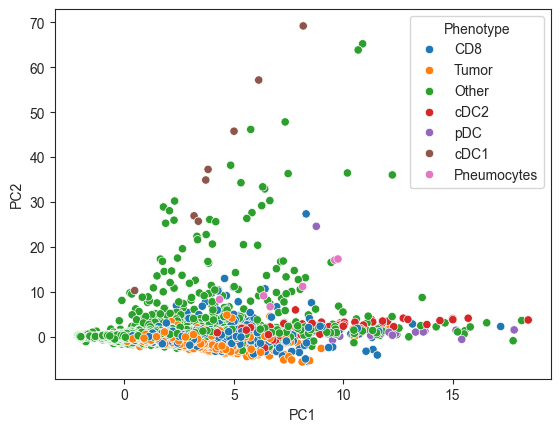

In [29]:
%matplotlib inline
sns.scatterplot(df, x= "PC1", y = "PC2", hue = "Phenotype")
plt.show()

In [30]:
pip install umap-learn

  Using cached umap_learn-0.5.5-py3-none-any.whl
  Using cached numba-0.59.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata (2.7 kB)
  Using cached pynndescent-0.5.11-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.42.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata (4.8 kB)
Using cached numba-0.59.0-cp39-cp39-macosx_10_9_x86_64.whl (2.6 MB)
Using cached pynndescent-0.5.11-py3-none-any.whl (55 kB)
Using cached llvmlite-0.42.0-cp39-cp39-macosx_10_9_x86_64.whl (31.1 MB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import umap

/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
reducer = umap.UMAP()
tsne = TSNE()

In [33]:
cols_phenotype = cols.copy()
cols_phenotype.append("Phenotype")

df = data[cols_phenotype]
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df.iloc[:,:-1])

In [34]:
embedding = reducer.fit_transform(scaled_df)
embedding.shape

(38220, 2)

In [ ]:
for i in range(embedding.shape[1]):
    column_name = f"UMAP {i+1}"
    df[column_name] = embedding[:,i]